# 👽👾 `print(fiction)` 📚🛸

> #### A data science project by _Tobias Reaper_

#### 📓 Notebook 2: Data Wrangling and Exploration 🔬

---

### Notebook Outline

* Intro
* Imports and configuration
* Data wrangling
  * Null values
  * Feature management
  * Distributions and outliers
* Exploration and visualization
  * Basic statistics

---

## Intro

[quick intro to project]

[explanation of this notebook in context of project]

---

### 📥 Initial Imports and Configuration ⚙️

In [1]:
# === General Imports === #
import pandas as pd
import numpy as np
import os
import janitor

In [2]:
# === ML Imports === #
# import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [3]:
# === Visualization === #
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
# Plotly imports
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.io as pio
pio.templates.default = "plotly_dark"  # Set to dark mode
# list(pio.templates)  # Get list of plotly themes

In [ ]:
# Jupyter + Plotly imports (if running in Colab or Visual Studio Code, comment out this cell)
import plotly.offline as pyo
pyo.init_notebook_mode()  # Set plotly to notebook mode / work offline

In [ ]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [4]:
# === Configure === #
%matplotlib inline
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200

---

## 📈 Data wrangling ⛓

### Load and view basic data properties

Now that I have the dataset, I'm going to load it up, do some basic wrangling, and look at some basic summary statistics.

* Deal with null values
* Remove extraneous features
* Fix data types as needed (some feature engineering involved)

To start, I'm going to take care of null values. Then I'll remove some extraneous columns— features that won't be useful to the model.

In [19]:
# === Load the dataset === #
# This version is directly from the scraping, minimal processing
data_path = "assets/must_read_books-01.csv"

books = pd.read_csv(data_path)
print(books.shape)
books.head(3)

(21514, 21)


,url,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,publish_date,original_publish_year,genres,characters,series,places,asin,0_rating_count,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count
0,https://www.goodreads.com/book/show/323355.The...,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,2013-10-22 00:00:00,1830.0,"['Lds', 'Church', 'Christianity', 'Religion', ...",NaN,NaN,NaN,NaN,NaN,7520.0,2697.0,2521.0,1963.0,56654.0
1,https://www.goodreads.com/book/show/28862.The_...,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,2003-06-01 00:00:00,1513.0,"['European Literature', 'Italian Literature', ...","['Theseus (mythology)', 'Alexander the Great',...",NaN,NaN,NaN,NaN,5254.0,16827.0,61182.0,80221.0,66231.0
2,https://www.goodreads.com/book/show/46654.The_...,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1974-01-01 00:00:00,1953.0,"['Science Fiction', 'Classics', 'Fiction']","['Hari Seldon', 'Salvor Hardin', 'Hober Mallow...",Foundation (Publication Order) #1-3,NaN,NaN,NaN,477.0,1521.0,9016.0,25447.0,47472.0


In [20]:
# === Basic info === #
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21514 entries, 0 to 21513
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    21514 non-null  object 
 1   title                  21513 non-null  object 
 2   author                 21513 non-null  object 
 3   num_ratings            21513 non-null  float64
 4   num_reviews            21513 non-null  float64
 5   avg_rating             21513 non-null  float64
 6   num_pages              20339 non-null  float64
 7   language               19366 non-null  object 
 8   publish_date           21078 non-null  object 
 9   original_publish_year  12839 non-null  float64
 10  genres                 18573 non-null  object 
 11  characters             5823 non-null   object 
 12  series                 7048 non-null   object 
 13  places                 5238 non-null   object 
 14  asin                   3953 non-null   object 
 15  0_

#### Feature management

Before digging deep into the data, there was some initial processing and pruning to be done to the features to make them more manageable later on.
Right off the bat I can remove some features that likely won't be useful in the model:

* url
* asin
* 0_rating_count
* characters
* places

'url' and 'asin' are obviously not going to be useful, just extra noise. As can be seen in the info table above, '0_rating_count' was completely null because GoodReads doesn't allow books to get zero stars.
I based my decision to remove 'characters' and 'places' on my domain knowledge and on the quality of their data. In my experience, nonfiction books are much less likely to be set in a particular location or have characters. On the one hand, this could be valuable information for the model to know: if the book has a list of characters, it is more likely to be fiction. On the other hand, that information could be too useful—i.e. it could leak information about the target.

Both have a high proportion of null values—over 50%, as can be seen in the table above—and I cannot be sure whether the null values represent the fact that users simply haven't taken the time to add that data to those books, or if those books really do not have any significant characters or places.

In [21]:
# === Drop extraneous features === #
drop_cols = [
    "url",
    "asin",
    "0_rating_count",
    "characters",
    "places",
]

books = books.drop(columns=drop_cols)

In [8]:
# === Check to be sure it worked as expected === #
books.head(2)

,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,publish_date,original_publish_year,genres,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,2013-10-22 00:00:00,1830.0,"['Lds', 'Church', 'Christianity', 'Religion', ...",NaN,7520.0,2697.0,2521.0,1963.0,56654.0
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,2003-06-01 00:00:00,1513.0,"['European Literature', 'Italian Literature', ...",NaN,5254.0,16827.0,61182.0,80221.0,66231.0


##### Data types

I did some initial feature engineering early on to make the features more manageable for me and usable for the model. More feature engineering will take place later on.
First, the 'publish_date' feature needed to be split up into its component parts (year, month, day), because Scikit-learn models can't directly use the datetime format. By splitting them up into integers,  their meaning can be preserved and the model can process them.

Second, I had to deal with nested data. Most notably, the 'genres' column was organized as an array of genres for each book. Because Pandas doesn't parse this kind of data by default, the column imported as the object (text) datatype. The best way I found to deal with it, without delving into natural language processing, was to break out each genre into its own column, one-hot encoding style.

This step was very important, as I used the genres to engineer the 'fiction' target.

> NOTE: these steps have to happen after the 'genre' null values are removed.

In [22]:
# === Break out publish_date into components === #

def book_pub_date(df: pd.DataFrame):
    """Deconcatenates book publish_date to three separate features
    for year, month, and day. Drops the original publish_date feature.
    """
    # Convert the "publish_date" column to datetime
    df["publish_date"] = pd.to_datetime(df["publish_date"], errors="coerce", infer_datetime_format=True)

    # Break out "publish_date" into dt components
    df["publish_year"] = df["publish_date"].dt.year
    df["publish_month"] = df["publish_date"].dt.month
    df["publish_day"] = df["publish_date"].dt.day
    
    df = df.drop(columns=["publish_date"])  # Drop the OG publish_date
    
    return df


books = book_pub_date(books)
books.head(2)

,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,original_publish_year,genres,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,1830.0,"['Lds', 'Church', 'Christianity', 'Religion', ...",NaN,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,1513.0,"['European Literature', 'Italian Literature', ...",NaN,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0


### Null values

A feature with a large proportion of null values is far less likely to be useful, as imputing (filling in) the missing data can add noise that would adversely affect the model. Therefore, a feature such as that will be considered extraneous and removed from the dataset. However, given a small enough proportion of null values, imputing or otherwise filling in the missing data is more able to preserve the patterns that exist in those features.

There is one specific feature for which I want to drop all rows that are null: 'genres'. Because I am going to be using this to engineer my target, I don't want to risk biasing the model by imputing the missing values.

The above table doesn't do a great job describing the null value situation. Below is a visualization (thanks to missingno) showing the distribution and proportion of null values per feature.

In [22]:
books.isnull().sum()

title                        1
author                       1
num_ratings                  1
num_reviews                  1
avg_rating                   1
num_pages                 1175
language                  2148
original_publish_year     8675
genres                    2941
series                   14466
1_rating_count            1295
2_rating_count            1295
3_rating_count            1295
4_rating_count            1295
5_rating_count            1295
publish_year               439
publish_month              439
publish_day                439
dtype: int64

Text(0.5, 1.0, 'Null values by feature')

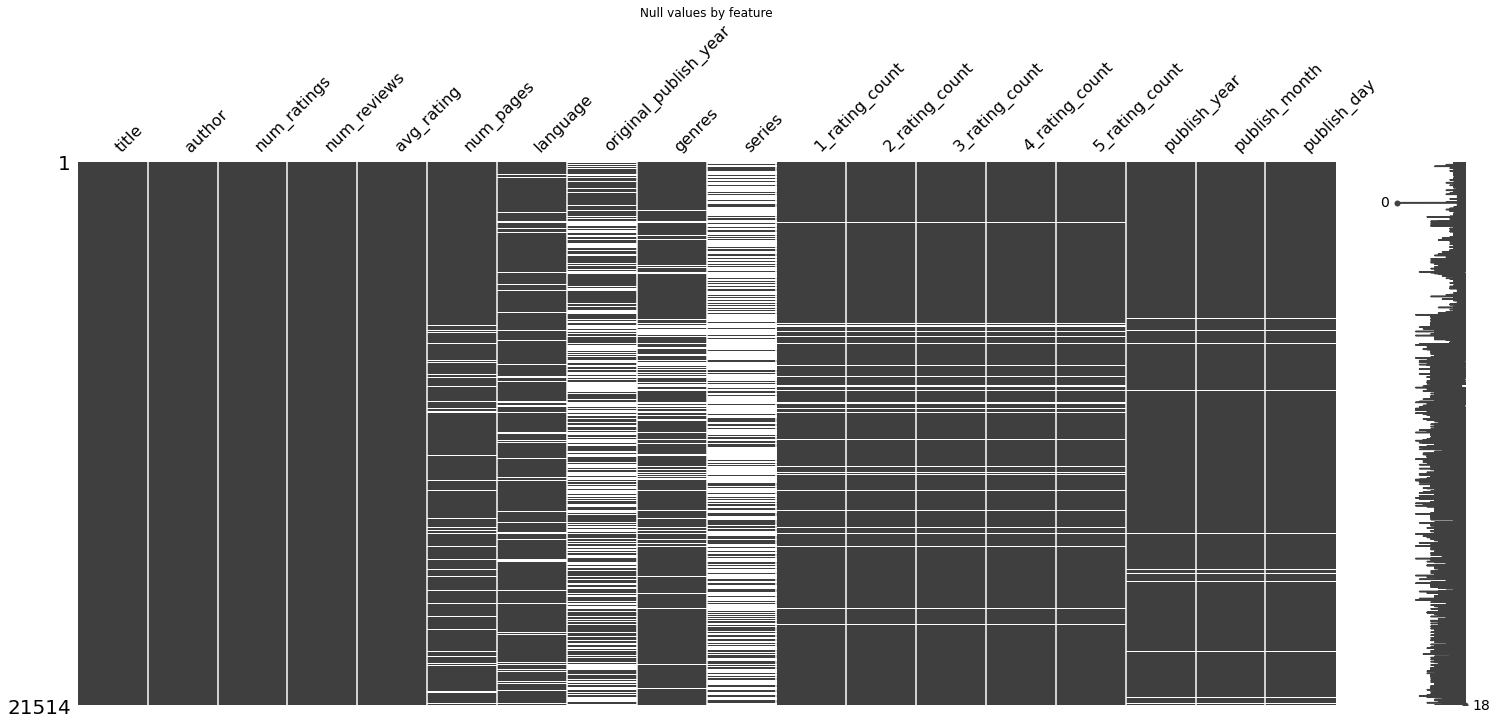

In [8]:
# === Use missingno to visualize nulls === #
# import missingno as msno
msno.matrix(books)
plt.title("Null values by feature")
# plt.tight_layout()
# plt.savefig("null_values_by_feature.png", dpi=80)

I used Scikit-learn's IterativeImputer to impute the missing values for many of the features with null values. The IterativeImputer class provides a whole suite of options to intelligently optimize how the values are imputed. But most importantly, it models each feature as a function of the other features, using that model to "predict" what the missing value would have been if it wasn't null.

There are a couple of features that had to be dealt with differently, 'original_publish_year' and 'series', as their null values actually held information.

For 'original_publish_year', I'm going to assume that a null value indicates that the book has not been previously published. And similarly for 'series', I'm assuming null indicates a standalone book. I transformed both of these features into binary: 0 indicating the value was null, 1 indicating it was not.

In [23]:
# === Drop rows with null "genres" === #
books = books.dropna(subset=["genres"])
print(books.shape)
books.head(2)

(18573, 18)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,original_publish_year,genres,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,1830.0,"['Lds', 'Church', 'Christianity', 'Religion', ...",NaN,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,1513.0,"['European Literature', 'Italian Literature', ...",NaN,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0


In [24]:
# === Encode the 'genres' feature === #

def encode_book_genres(df: pd.DataFrame):
    """Deconcatenates top 30 book genres into
    separate features, OneHotEncoding style.
    """
    from ast import literal_eval
    
    # === Convert 'genres' to python list === #
    df["genres"] = df["genres"].apply(literal_eval)
    
    # Create a set of all distinct genres listed in dataset
    all_genres = {genre for row_genres in df["genres"] for genre in row_genres}

    # Create a new feature for every genre
    for genre in all_genres:
        has_genre = lambda g: genre in g
        df[genre] = df.genres.apply(has_genre)

    # Create list of top 30 most common genres
    # NOTE: I ended up only using 'fiction', the top result
    most_common_genres = df[list(all_genres)].sum().sort_values(ascending=False).head(1)
    most_common_genres = most_common_genres.index.tolist()
    
    # Drop all but the top 30 genres from the dataframe
    unwanted_genres = list(all_genres - set(most_common_genres))
    df = df.drop(columns=unwanted_genres)
    
    # Drop the original "genres" feature
    df = df.drop(columns=["genres"])
    
    # Convert from Boolean to binary
    df = df.replace(to_replace={True: 1, False:0})
    
    # Format column names with pyjanitor
    df = (df.clean_names())
    
    return df


books = encode_book_genres(books)
books.head(2)

,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,original_publish_year,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,1830.0,NaN,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,1513.0,NaN,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0


In [25]:
# === Convert series to binary / boolean === #
books["series"] = books["series"].notnull().replace(to_replace={True: 1, False:0})
books["series"].value_counts()

0    11788
1     6785
Name: series, dtype: int64

In [26]:
# === Convert original_publish_year to binary / boolean === #
books["republish"] = books["original_publish_year"].notnull().replace(to_replace={True: 1, False:0})
books = books.drop(columns=["original_publish_year"])
books["republish"].value_counts()

1    12209
0     6364
Name: republish, dtype: int64

In [27]:
books.dtypes

title              object
author             object
num_ratings       float64
num_reviews       float64
avg_rating        float64
num_pages         float64
language           object
series              int64
1_rating_count    float64
2_rating_count    float64
3_rating_count    float64
4_rating_count    float64
5_rating_count    float64
publish_year      float64
publish_month     float64
publish_day       float64
fiction             int64
republish           int64
dtype: object

---

## Exploration and visualization

In [29]:
# === Basic descriptive statistics of numeric data === #
books.describe().T

,count,mean,std,min,25%,50%,75%,max
num_ratings,18573.0,46958.564906,212398.096869,0.0,387.00,4135.00,23108.00,6144613.0
num_reviews,18573.0,2289.266247,7681.862032,0.0,41.00,271.00,1380.00,163981.0
avg_rating,18573.0,4.029929,0.303335,0.0,3.84,4.04,4.22,5.0
num_pages,17897.0,340.212661,249.007716,0.0,221.00,307.00,402.00,8124.0
series,18573.0,0.365315,0.481531,0.0,0.00,0.00,1.00,1.0
1_rating_count,18490.0,1049.250135,6484.347528,0.0,7.00,70.00,383.00,509660.0
2_rating_count,18490.0,2270.299459,10177.791045,0.0,19.00,202.00,1080.00,497885.0
3_rating_count,18490.0,8248.047864,32751.345253,0.0,72.00,829.00,4465.75,916924.0
4_rating_count,18490.0,15479.218983,65574.246998,0.0,132.00,1443.00,8043.50,1760651.0
5_rating_count,18490.0,20122.527582,105326.268552,0.0,145.00,1479.50,8700.25,3954496.0


In [30]:
# === Look at categorical features === #
books.describe(exclude="number").T.sort_values(by="unique")

,count,unique,top,freq
language,17214,55,English,15909
author,18573,10019,Stephen King,79
title,18573,17816,The Nightingale,6


### Duplicates? ^^^

> Or...republished?

In [32]:
books.head()

,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,series,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,publish_year,publish_month,publish_day,fiction,republish
0,The Book of Mormon: Another Testament of Jesus...,Anonymous,71355.0,5704.0,4.37,531.0,English,0,7520.0,2697.0,2521.0,1963.0,56654.0,2013.0,10.0,22.0,0,1
1,The Prince,Niccolò Machiavelli,229715.0,7261.0,3.81,140.0,English,0,5254.0,16827.0,61182.0,80221.0,66231.0,2003.0,6.0,1.0,0,1
2,The Foundation Trilogy,Isaac Asimov,83933.0,1331.0,4.40,679.0,English,1,477.0,1521.0,9016.0,25447.0,47472.0,1974.0,1.0,1.0,1,1
3,From the Mixed-Up Files of Mrs. Basil E. Frank...,E.L. Konigsburg,173617.0,6438.0,4.15,178.0,English,0,2742.0,6381.0,29358.0,58559.0,76577.0,2003.0,6.0,2.0,1,1
4,A Room of One's Own,Virginia Woolf,98164.0,5848.0,4.14,112.0,English,0,1357.0,3778.0,15993.0,35876.0,41160.0,2000.0,1.0,1.0,0,1


#### Feature relationships

* 2D scatter plots (scatter matrix)
* 3D+ plots (color, size, etc)
  * Look at the plotly docs

In [10]:
# === See resulting shape === #
books.shape

(18047, 25)

### Distributions and outliers

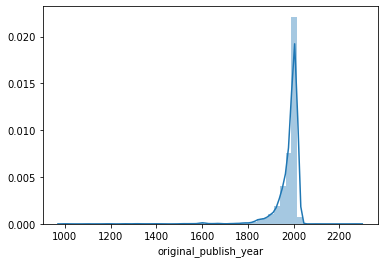

In [16]:
# === Distribution of 'original_publish_year' === #
sns.distplot(books["original_publish_year"]);

### Visualizing outliers

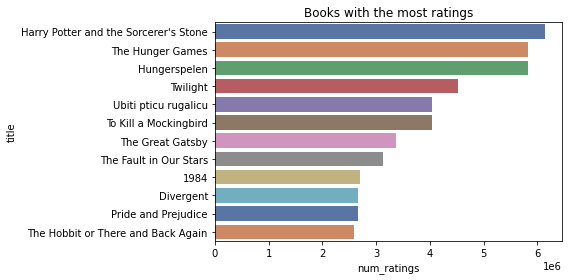

In [41]:
# === Books with the most ratings === #
hiratings = books.nlargest(20, ["num_ratings"]).set_index("title")["num_ratings"]
plt.figure(figsize=(8, 4))
sns.barplot(hiratings, hiratings.index, palette="deep")
plt.title("Books with the most ratings");
plt.tight_layout()
plt.savefig("books_most_ratings.png", dpi=160)

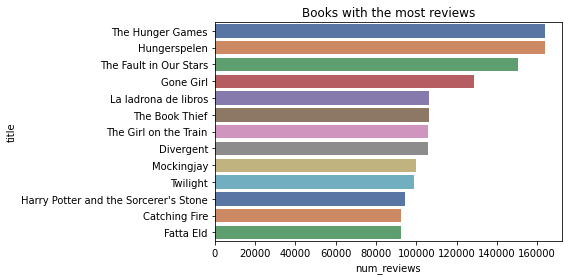

In [59]:
# Books with the most reviews
hireviews = books.nlargest(24, ["num_reviews"]).set_index("title")["num_reviews"]
plt.figure(figsize=(8, 4))
sns.barplot(hireviews, hireviews.index, palette="deep")
plt.title("Books with the most reviews")
plt.tight_layout();
plt.savefig("books_most_reviews.png", dpi=160)

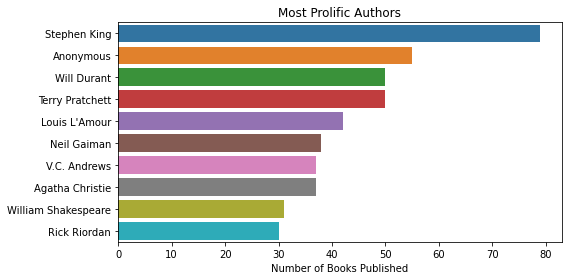

In [61]:
# Most prolific authors
prolifics = books["author"].value_counts().head(10)
plt.figure(figsize=(8, 4))
sns.barplot(prolifics, prolifics.index)
plt.title("Most Prolific Authors")
plt.tight_layout()
plt.xlabel("Number of Books Published");
plt.savefig("authors_most_books.png", dpi=160)

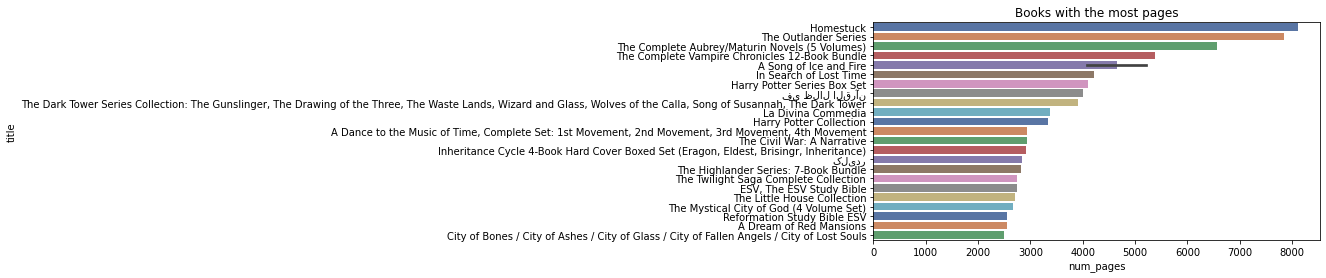

In [62]:
# === Books with the most pages === #
hipages = books.nlargest(24, ["num_pages"]).set_index("title")["num_pages"]
plt.figure(figsize=(8, 4))
sns.barplot(hipages, hipages.index, palette="deep")
plt.title("Books with the most pages");
# plt.savefig("books_most_pages.png", dpi=160)

In [63]:
hipages

title
Homestuck                                                                                                                                                               8124.0
The Outlander Series                                                                                                                                                    7852.0
The Complete Aubrey/Maturin Novels (5 Volumes)                                                                                                                          6576.0
The Complete Vampire Chronicles 12-Book Bundle                                                                                                                          5392.0
A Song of Ice and Fire                                                                                                                                                  5216.0
In Search of Lost Time                                                                                                 

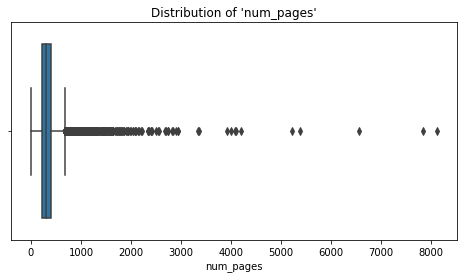

In [51]:
# === Boxplot to view outliers === #
plt.figure(figsize=(8, 4))
sns.boxplot(x=books["num_pages"])
plt.title("Distribution of 'num_pages'");
plt.savefig("num_pages_boxplot.png", dpi=160)

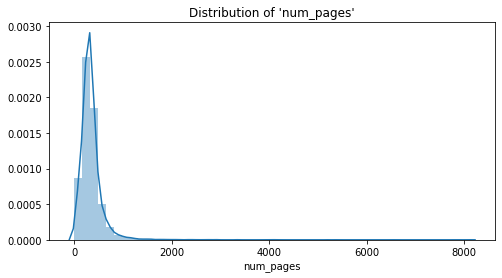

In [50]:
# === Distribution plot === #
plt.figure(figsize=(8, 4))
sns.distplot(books["num_pages"])
plt.title("Distribution of 'num_pages'");
plt.savefig("num_pages_distplot.png", dpi=160)

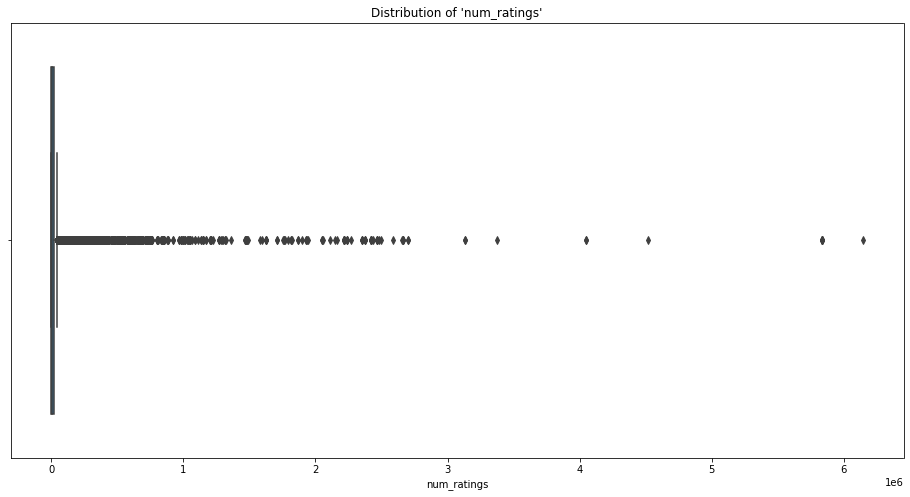

In [18]:
# === Boxplot to view outliers === #
plt.figure(figsize=(16, 8))
sns.boxplot(x=books["num_ratings"])
plt.title("Distribution of 'num_ratings'");
# plt.savefig("num_ratings_boxplot.png", dpi=160)

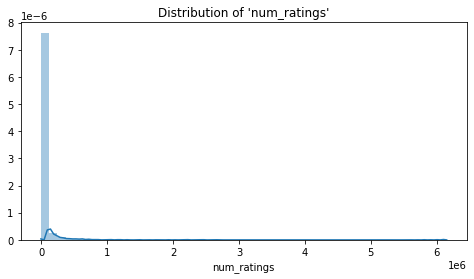

In [21]:
# === Distribution === #
plt.figure(figsize=(8, 4))
sns.distplot(books["num_ratings"])
plt.title("Distribution of 'num_ratings'");
# plt.savefig("num_ratings_distplot.png", dpi=160)

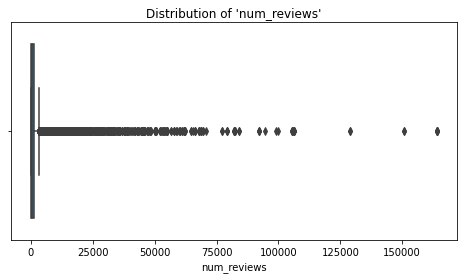

In [54]:
# To find outliers in numerical features, utilize boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x=books["num_reviews"])
plt.title("Distribution of 'num_reviews'");
plt.savefig("num_reviews_boxplot.png", dpi=160)

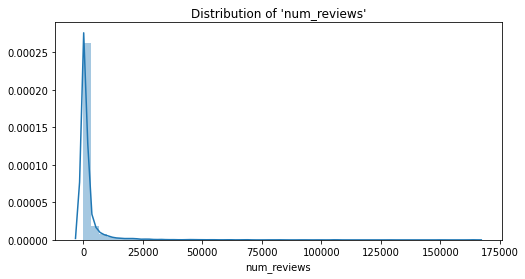

In [55]:
plt.figure(figsize=(8, 4))
sns.distplot(books["num_reviews"])
plt.title("Distribution of 'num_reviews'");
plt.savefig("num_reviews_distplot.png", dpi=160)

### Removing outliers

In [66]:
# See how much removing pages outliers affects dataset
# This could even be one of the sliders on the app
cutoff = 3000
books_pages = books[books["num_pages"] <= cutoff]
print(f"There are {books.shape[0] - books_pages.shape[0]} books above {cutoff} pages long.")
print(f"The resulting dataset has {books_pages.shape[0]} rows.")

There are 688 books above 3000 pages long.
The resulting dataset has 17885 rows.


In [68]:
# === Glance at the books over 3000 pages long === #
books_over_cutoff = books[books["num_pages"] > cutoff]
print(books_over_cutoff.shape)
books_over_cutoff

(12, 48)


,title,author,num_ratings,num_reviews,avg_rating,num_pages,language,european_literature,memoir,fantasy,religion,horror,humor,historical_fiction,classics,adventure,autobiography,nonfiction,novels,biography,war,paranormal,historical,thriller,cultural,philosophy,childrens,literature,young_adult,mystery,science_fiction,contemporary,crime,history,romance,fiction,short_stories,publish_year,publish_month,publish_day,1_rating_count,2_rating_count,3_rating_count,4_rating_count,5_rating_count,in_series,has_charlist,has_setting
271,In Search of Lost Time,Marcel Proust,9249.0,515.0,4.34,4211.0,English,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,2003.0,6.0,3.0,249.0,365.0,965.0,2045.0,5625.0,1,0,0
373,A Song of Ice and Fire,George R.R. Martin,43149.0,1011.0,4.63,4081.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2011.0,3.0,22.0,248.0,469.0,2168.0,9267.0,30997.0,1,0,0
1575,Harry Potter Series Box Set,J.K. Rowling,233318.0,7048.0,4.74,4100.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2007.0,10.0,1.0,1434.0,1536.0,7828.0,34119.0,188401.0,1,0,0
3519,The Dark Tower Series Collection: The Gunsling...,Stephen King,9285.0,343.0,4.61,3914.0,English,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2011.0,7.0,22.0,100.0,134.0,524.0,1788.0,6739.0,1,0,0
3754,A Song of Ice and Fire,George R.R. Martin,46238.0,1549.0,4.63,5216.0,English,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2011.0,7.0,22.0,296.0,510.0,2342.0,9913.0,33177.0,1,1,0
6745,Homestuck,Andrew Hussie,1280.0,182.0,4.67,8124.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,2016.0,4.0,13.0,25.0,13.0,56.0,170.0,1016.0,1,0,0
6867,The Outlander Series,Diana Gabaldon,8271.0,414.0,4.73,7852.0,English,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,2012.0,10.0,29.0,44.0,62.0,309.0,1246.0,6610.0,1,0,0
9649,La Divina Commedia,Dante Alighieri,103704.0,3390.0,4.07,3367.0,Italian,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2007.0,10.0,23.0,1555.0,5196.0,20328.0,34366.0,42259.0,1,1,0
11296,Harry Potter Collection,J.K. Rowling,29527.0,920.0,4.73,3342.0,English,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2005.0,9.0,12.0,250.0,209.0,1040.0,4268.0,23760.0,1,0,0
12270,في ظلال القرآن,Sayed Qutb,3312.0,135.0,4.52,4012.0,Arabic,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2008.0,10.0,23.0,102.0,65.0,230.0,536.0,2379.0,1,0,0


In [27]:
# See how much removing ratings outliers affects dataset
cutoff = 1940
df6 = df5[df5["publish_year"] >= cutoff]
print(f"There are {df5.shape[0] - df6.shape[0]} books published before {cutoff}.")
print(f"The resulting dataset has {df6.shape[0]} rows.")

There are 216 books published before 1940.
The resulting dataset has 16960 rows.


#### Distribution of target

The distribution, or skew, of the target variable will help determine the best choice of model metric. If the target is wildly skewed one way or another, accuracy is not a good measure of how well a classification model is performing.

In this case, the distribution of the binary target `fiction` was relatively equally distributed between the two  classes.

In [13]:
# === Distribution of target === #
books["fiction"].value_counts()

1    9745
0    8828
Name: fiction, dtype: int64